# Streamlined KL-Divergence Based Clustering Analysis

This notebook provides a streamlined workflow for performing KL-divergence based hierarchical clustering with:
- Automated correlation threshold selection using the elbow method
- Clean cluster extraction with significance testing
- Comprehensive visualization with cluster boundary dendrograms
- Cluster recovery evaluation


## Imports and Class Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS  # For multidimensional scaling dimensionality reduction
from multiprocessing import Pool, cpu_count
import time
import warnings

# Silence warnings
warnings.filterwarnings('ignore')

# Node Class Definition
class Node:
    """A simple class to represent a node in a tree."""
    def __init__(self, name):
        self.name = name
        self.children = []
        self.distribution = None
        self.kl_divergence_per_column = None
        self.kl_divergence = None
        self.leaf_count = 0
        self.p_value = None
        self.is_significant_zero_centered = None
        self.is_significant_adaptive = None
        self.is_significant_bonferroni = None

    def add_child(self, child_node):
        """Add a child node to this node's children list"""
        self.children.append(child_node)

    def is_leaf(self):
        """Check if this node is a leaf (has no children)"""
        return not self.children

In [1]:
def generate_random_feature_matrix(n_rows, n_cols, entropy_param=0.5, n_clusters=2, random_seed=None, balanced_clusters=True):
    """Generate a random binary feature matrix with controllable clustering entropy."""
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_clusters = max(1, min(n_clusters, n_rows))
    leaf_matrix_dict = {}
    cluster_assignments = {}
    
    if balanced_clusters or n_clusters == 1:
        samples_per_cluster = n_rows // n_clusters
        remainder = n_rows % n_clusters
        cluster_sizes = [samples_per_cluster + (1 if i < remainder else 0) for i in range(n_clusters)]
    else:
        remaining = n_rows - n_clusters
        cluster_sizes = [1] * n_clusters
        for _ in range(remaining):
            idx = np.random.randint(0, n_clusters)
            cluster_sizes[idx] += 1
    
    if entropy_param == 1.0 or n_clusters == 1:
        template = [1] * n_cols
        for i in range(n_rows):
            leaf_matrix_dict[f'L{i+1}'] = template.copy()
            cluster_assignments[f'L{i+1}'] = 0
    elif entropy_param == 0.0:
        cluster_templates = []
        if n_clusters == 2:
            cluster_templates = [[0] * n_cols, [1] * n_cols]
        else:
            for cluster_id in range(n_clusters):
                prob_ones = cluster_id / (n_clusters - 1) if n_clusters > 1 else 0.5
                template = np.random.choice([0, 1], size=n_cols, p=[1-prob_ones, prob_ones]).tolist()
                cluster_templates.append(template)
        
        sample_idx = 0
        for cluster_id, current_cluster_size in enumerate(cluster_sizes):
            for _ in range(current_cluster_size):
                leaf_matrix_dict[f'L{sample_idx+1}'] = cluster_templates[cluster_id].copy()
                cluster_assignments[f'L{sample_idx+1}'] = cluster_id
                sample_idx += 1
    else:
        if entropy_param < 0.5:
            noise_prob = entropy_param * 2
            cluster_templates = []
            for cluster_id in range(n_clusters):
                prob_ones = cluster_id / (n_clusters - 1) if n_clusters > 1 else 0.5
                template = np.random.choice([0, 1], size=n_cols, p=[1-prob_ones, prob_ones])
                cluster_templates.append(template)
            
            sample_idx = 0
            for cluster_id, current_cluster_size in enumerate(cluster_sizes):
                base_template = cluster_templates[cluster_id]
                for _ in range(current_cluster_size):
                    sample = []
                    for j in range(n_cols):
                        if np.random.random() < noise_prob:
                            sample.append(1 - base_template[j])
                        else:
                            sample.append(base_template[j])
                    leaf_matrix_dict[f'L{sample_idx+1}'] = sample
                    cluster_assignments[f'L{sample_idx+1}'] = cluster_id
                    sample_idx += 1
        else:
            cluster_convergence = (entropy_param - 0.5) * 2
            cluster_templates = []
            base_template = np.random.choice([0, 1], size=n_cols).tolist()
            for cluster_id in range(n_clusters):
                if cluster_convergence > np.random.random():
                    cluster_templates.append(base_template.copy())
                else:
                    cluster_templates.append(np.random.choice([0, 1], size=n_cols).tolist())
            
            sample_idx = 0
            for cluster_id, current_cluster_size in enumerate(cluster_sizes):
                template = cluster_templates[cluster_id]
                for _ in range(current_cluster_size):
                    sample = []
                    for j in range(n_cols):
                        if np.random.random() < cluster_convergence:
                            sample.append(template[j])
                        else:
                            sample.append(np.random.choice([0, 1]))
                    leaf_matrix_dict[f'L{sample_idx+1}'] = sample
                    cluster_assignments[f'L{sample_idx+1}'] = cluster_id
                    sample_idx += 1
    
    feature_sums = [0] * n_cols
    for sample_vector in leaf_matrix_dict.values():
        for j in range(n_cols):
            feature_sums[j] += sample_vector[j]
    
    missing_features = [j for j in range(n_cols) if feature_sums[j] == 0]
    if missing_features:
        leaf_names = list(leaf_matrix_dict.keys())
        for feature_idx in missing_features:
            random_sample = np.random.choice(leaf_names)
            leaf_matrix_dict[random_sample][feature_idx] = 1
    
    return leaf_matrix_dict, cluster_assignments

## Helper Functions

In [7]:
def calculate_distributions(node, leaf_data):
    """Recursively calculates the mean distribution for each node."""
    if node.is_leaf():
        node.distribution = np.array(leaf_data[node.name])
        node.leaf_count = 1
    else:
        for child in node.children:
            calculate_distributions(child, leaf_data)
        node.leaf_count = sum(c.leaf_count for c in node.children)
        sum_vector = np.zeros(len(node.children[0].distribution))
        for child in node.children:
            sum_vector += child.distribution * child.leaf_count
        node.distribution = sum_vector / node.leaf_count

def calculate_kl_divergence_vector(q_dist, p_dist):
    """Calculates the KL divergence for each feature column."""
    epsilon = 1e-9
    q = np.clip(q_dist, epsilon, 1 - epsilon)
    p = np.clip(p_dist, epsilon, 1 - epsilon)
    divergence_vector = q * np.log(q / p) + (1 - q) * np.log((1 - q) / (1 - p))
    return divergence_vector


def get_all_internal_nodes(node, node_list):
    """Traverses the tree to collect all internal nodes."""
    if not node.is_leaf():
        node_list.append(node)
        for child in node.children:
            get_all_internal_nodes(child, node_list)


def build_tree_from_dendrogram(Z, leaf_names, leaf_data):
    """Build tree structure from hierarchical clustering results."""
    leaf_nodes = {name: Node(name) for name in leaf_names}
    num_leaves = len(leaf_names)
    num_merges = Z.shape[0]
    all_nodes = {**leaf_nodes}
    merge_nodes = []
    
    for i in range(num_merges):
        node_name = "R" if i == num_merges - 1 else f'N{num_merges - i}'
        node = Node(node_name)
        left_idx = int(Z[i, 0])
        right_idx = int(Z[i, 1])
        
        if left_idx < num_leaves:
            left_child = leaf_nodes[leaf_names[left_idx]]
        else:
            left_child = merge_nodes[left_idx - num_leaves]
        
        if right_idx < num_leaves:
            right_child = leaf_nodes[leaf_names[right_idx]]
        else:
            right_child = merge_nodes[right_idx - num_leaves]
        
        node.add_child(left_child)
        node.add_child(right_child)
        merge_nodes.append(node)
        all_nodes[node_name] = node
    
    root = merge_nodes[-1]
    calculate_distributions(root, leaf_data)
    internal_nodes = []
    get_all_internal_nodes(root, internal_nodes)
    overall_mean_dist = root.distribution
    
    for node in internal_nodes:
        node.kl_divergence_per_column = calculate_kl_divergence_vector(node.distribution, overall_mean_dist)
        node.kl_divergence = np.sum(node.kl_divergence_per_column)
    
    return root, internal_nodes

In [9]:
def plot_enhanced_dendrogram_with_significance(Z, leaf_names, node_summary_df):
    """
    Create enhanced dendrogram with significance annotations and visual indicators.
    
    Parameters:
    -----------
    Z : ndarray
        Linkage matrix from hierarchical clustering
    leaf_names : list
        Names of leaf nodes in dendrogram order
    node_summary_df : DataFrame
        Summary of node significance results with columns: 'Node', 'P_Value', 'Bonferroni_Result'
    """
    # Create a mapping from node names to their statistical data
    node_info = {}
    for _, row in node_summary_df.iterrows():
        node_info[row['Node']] = {
            'p_value': row['P_Value'],
            'bonferroni_significant': row['Bonferroni_Result'] == 'Significant'
        }
    
    # Create the enhanced dendrogram with larger figure for better visibility
    plt.figure(figsize=(14, 8))
    dendro_plot = dendrogram(Z, labels=leaf_names, leaf_rotation=90, color_threshold=0)
    
    # Extract coordinate information from dendrogram for annotation placement
    icoord = dendro_plot['icoord']
    dcoord = dendro_plot['dcoord']
    
    # Use linkage matrix to map dendrogram order to node names
    num_leaves = len(leaf_names)
    num_merges = Z.shape[0]
    
    # Build mapping from dendrogram position to linkage matrix index
    dendro_to_linkage = {}
    
    for dendro_idx in range(len(dcoord)):
        y_height = dcoord[dendro_idx][1]
        x_center = (icoord[dendro_idx][1] + icoord[dendro_idx][2]) / 2
        
        # Find all linkage matrix rows with this height
        height_matches = []
        for link_idx in range(num_merges):
            if abs(Z[link_idx, 2] - y_height) < 1e-10:
                height_matches.append(link_idx)
        
        if len(height_matches) == 1:
            dendro_to_linkage[dendro_idx] = height_matches[0]
        elif len(height_matches) > 1:
            unassigned = [idx for idx in height_matches if idx not in dendro_to_linkage.values()]
            
            if len(unassigned) == 1:
                dendro_to_linkage[dendro_idx] = unassigned[0]
            elif len(unassigned) > 1:
                best_match = None
                best_distance = float('inf')
                
                for candidate_idx in unassigned:
                    left_idx = int(Z[candidate_idx, 0])
                    right_idx = int(Z[candidate_idx, 1])
                    
                    if left_idx < num_leaves:
                        left_x = dendro_plot['ivl'].index(leaf_names[left_idx]) * 10
                    else:
                        left_dendro_idx = [k for k, v in dendro_to_linkage.items() if v == left_idx - num_leaves]
                        if left_dendro_idx:
                            left_x = (icoord[left_dendro_idx[0]][1] + icoord[left_dendro_idx[0]][2]) / 2
                        else:
                            left_x = x_center
                    
                    if right_idx < num_leaves:
                        right_x = dendro_plot['ivl'].index(leaf_names[right_idx]) * 10
                    else:
                        right_dendro_idx = [k for k, v in dendro_to_linkage.items() if v == right_idx - num_leaves]
                        if right_dendro_idx:
                            right_x = (icoord[right_dendro_idx[0]][1] + icoord[right_dendro_idx[0]][2]) / 2
                        else:
                            right_x = x_center
                    
                    expected_x = (left_x + right_x) / 2
                    distance = abs(expected_x - x_center)
                    
                    if distance < best_distance:
                        best_distance = distance
                        best_match = candidate_idx
                
                dendro_to_linkage[dendro_idx] = best_match if best_match is not None else unassigned[0]
    
    # Add annotations for each internal node
    for i in range(len(icoord)):
        x_pos = (icoord[i][1] + icoord[i][2]) / 2
        y_pos = dcoord[i][1]
        
        # Get the correct linkage matrix index
        if i in dendro_to_linkage:
            link_idx = dendro_to_linkage[i]
            if link_idx == num_merges - 1:
                node_name = 'R'
            else:
                node_name = f'N{num_merges - link_idx}'
        else:
            if i == num_merges - 1:
                node_name = 'R'
            else:
                node_name = f'N{num_merges - i}'
        
        # Get node information if available
        if node_name in node_info:
            p_val = node_info[node_name]['p_value']
            is_significant = node_info[node_name]['bonferroni_significant']
            
            # Choose visual style based on significance
            color = 'red' if is_significant else 'blue'
            marker = 'o' if is_significant else 's'
            
            # Plot the node marker
            plt.plot(x_pos, y_pos, marker, color=color, markersize=8, 
                    markeredgecolor='black', markeredgewidth=1)
            
            # Add text annotation with node name and p-value
            plt.annotate(f'{node_name}\np={p_val:.2e}',
                        xy=(x_pos, y_pos),
                        xytext=(5, 10),
                        textcoords='offset points',
                        fontsize=9,
                        color=color,
                        weight='bold' if is_significant else 'normal',
                        bbox=dict(boxstyle='round,pad=0.3',
                                facecolor='white',
                                edgecolor=color,
                                alpha=0.8))
    
    # Add title and labels
    plt.title('Enhanced Dendrogram with Node Identifiers and P-Values\n' +
              'Red circles = Bonferroni significant, Blue squares = Not significant')
    plt.xlabel('Leaf Nodes')
    plt.ylabel('Distance (Hamming)')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=8, label='Significant (Bonferroni)'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', 
               markersize=8, label='Not Significant')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return dendro_plot

## Main Clustering Analysis Function

In [5]:
def run_kl_clustering_analysis(leaf_matrix_dict, alpha=0.05, correlation_threshold='auto', 
                               significance_column='Bonferroni_Result'):
    """
    Run complete KL-divergence based clustering analysis.
    
    Parameters:
    -----------
    leaf_matrix_dict : dict
        Dictionary mapping leaf names to binary feature vectors
    alpha : float
        Significance level for hypothesis testing (default: 0.05)
    correlation_threshold : float or 'auto'
        Threshold for correlation-based cluster refinement.
        If 'auto', uses elbow method to determine optimal threshold.
    significance_column : str
        Column name to use for significance determination
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'predicted_clusters': cluster assignments
        - 'plots': dictionary of plot figures
        - 'results': detailed analysis results
    """
    print("="*60)
    print("STEP 1: Hierarchical Clustering")
    print("="*60)
    
    # Perform hierarchical clustering
    Z = sch.linkage(list(leaf_matrix_dict.values()), method='complete', metric='hamming')
    
    # Create initial dendrogram
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    dendro = dendrogram(Z, labels=list(leaf_matrix_dict.keys()), leaf_rotation=90, ax=ax1)
    ax1.set_title('Dendrogram of Leaf Nodes', fontsize=14, weight='bold')
    ax1.set_xlabel('Leaf Nodes', fontsize=12)
    ax1.set_ylabel('Distance (Hamming)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Build tree structure
    leaf_names_original = list(leaf_matrix_dict.keys())
    root, internal_nodes = build_tree_from_dendrogram(Z, leaf_names_original, leaf_matrix_dict)
    
    print("\n" + "="*60)
    print("STEP 2: Significance Testing")
    print("="*60)
    
    # Perform significance testing
    num_columns = len(root.distribution)
    kl_divergences = [node.kl_divergence for node in internal_nodes]
    mean_kl = np.mean(kl_divergences)
    std_kl = np.std(kl_divergences)
    threshold_zero_centered = 2 * std_kl
    threshold_adaptive = mean_kl + 2 * std_kl
    
    for node in internal_nodes:
        chi2_stat = 2 * node.leaf_count * node.kl_divergence
        node.p_value = chi2.sf(chi2_stat, df=num_columns)
        corrected_alpha = alpha / node.leaf_count
        node.is_significant_bonferroni = node.p_value < corrected_alpha
        node.is_significant_zero_centered = node.kl_divergence > threshold_zero_centered
        node.is_significant_adaptive = node.kl_divergence > threshold_adaptive
    
    # Create summary DataFrame
    summary_data = []
    for node in internal_nodes:
        summary_data.append({
            'Node': node.name,
            'Mean_of_Distribution': np.mean(node.distribution),
            'Variance_of_Distribution': np.var(node.distribution),
            'P_Value': node.p_value,
            'Bonferroni_Result': "Significant" if node.is_significant_bonferroni else "Not Significant",
            'Zero_Centered_Result': "Significant" if node.is_significant_zero_centered else "Not Significant",
            'Adaptive_Result': "Significant" if node.is_significant_adaptive else "Not Significant"
        })
    node_summary_df = pd.DataFrame(summary_data)
    
    print(f"Number of internal nodes: {len(internal_nodes)}")
    print(f"Significant nodes (Bonferroni): {node_summary_df['Bonferroni_Result'].value_counts().get('Significant', 0)}")
    
    # Plot enhanced dendrogram with significance annotations
    plot_enhanced_dendrogram_with_significance(Z, leaf_names_original, node_summary_df)
    
    print("\n" + "="*60)
    print("STEP 3: Correlation Analysis & Threshold Selection")
    print("="*60)
    
    # Calculate optimal threshold if auto
    if correlation_threshold == 'auto':
        print("Using elbow method to determine optimal correlation threshold...")
        optimal_threshold, sorted_improvements, sorted_node_names, elbow_index = \
            _calculate_optimal_threshold(Z, leaf_names_original, node_summary_df, 
                                        leaf_matrix_dict, significance_column)
        
        # Plot elbow analysis
        fig2, axes = plt.subplots(1, 2, figsize=(16, 5))
        ax1 = axes[0]
        x_indices = np.arange(len(sorted_improvements))
        ax1.plot(x_indices, sorted_improvements, 'b-', linewidth=2, label='Correlation advantages')
        ax1.scatter(x_indices, sorted_improvements, c='blue', s=50, alpha=0.6)
        ax1.axvline(x=elbow_index, color='red', linestyle='--', linewidth=2, label=f'Elbow (index {elbow_index})')
        ax1.axhline(y=optimal_threshold, color='red', linestyle=':', linewidth=2, alpha=0.7,
                   label=f'Threshold: {optimal_threshold:.4f}')
        ax1.scatter([elbow_index], [optimal_threshold], c='red', s=200, marker='*',
                   edgecolors='black', linewidths=2, zorder=5, label='Optimal point')
        ax1.set_xlabel('Node rank (sorted by correlation advantage)', fontsize=11)
        ax1.set_ylabel('Correlation advantage over parent', fontsize=11)
        ax1.set_title('Elbow Method: Sorted Correlation Advantages', fontsize=12, weight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=10)
        
        ax2 = axes[1]
        if len(sorted_improvements) >= 3:
            x_norm = np.linspace(0, 1, len(sorted_improvements))
            first_deriv = np.diff(sorted_improvements) / np.diff(x_norm)
            second_deriv = np.diff(first_deriv) / np.diff(x_norm[:-1])
            x_second_deriv = np.arange(1, len(sorted_improvements) - 1)
            ax2.plot(x_second_deriv, np.abs(second_deriv), 'g-', linewidth=2, label='|Second derivative|')
            ax2.scatter(x_second_deriv, np.abs(second_deriv), c='green', s=50, alpha=0.6)
            ax2.axvline(x=elbow_index, color='red', linestyle='--', linewidth=2, label=f'Max curvature')
            ax2.scatter([elbow_index], [np.abs(second_deriv[elbow_index-1])], c='red', s=200, marker='*',
                       edgecolors='black', linewidths=2, zorder=5, label='Elbow point')
            ax2.set_xlabel('Node rank', fontsize=11)
            ax2.set_ylabel('Absolute curvature', fontsize=11)
            ax2.set_title('Second Derivative: Maximum Curvature', fontsize=12, weight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
        
        correlation_threshold = optimal_threshold
        print(f"Optimal correlation threshold: {correlation_threshold:.4f}")
    else:
        print(f"Using manual correlation threshold: {correlation_threshold:.4f}")
    
    print("\n" + "="*60)
    print("STEP 4: Cluster Extraction")
    print("="*60)
    
    # Extract clusters
    predicted_clusters, boundary_nodes, boundary_reasons = _extract_clusters_from_tree(
        Z, leaf_names_original, node_summary_df, leaf_matrix_dict,
        significance_column, correlation_threshold
    )
    
    # Analyze correlation patterns
    correlation_analysis_df = _analyze_correlation_patterns(
        Z, leaf_names_original, node_summary_df, leaf_matrix_dict, significance_column
    )
    
    print("\n" + "="*60)
    print("STEP 5: Visualization")
    print("="*60)
    
    # Create cluster boundary dendrogram
    _plot_cluster_boundary_dendrogram(Z, leaf_names_original, predicted_clusters,
                                     correlation_analysis_df, node_summary_df,
                                     boundary_nodes, boundary_reasons)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
    
    return {
        'predicted_clusters': predicted_clusters,
        'node_summary': node_summary_df,
        'correlation_analysis': correlation_analysis_df,
        'correlation_threshold': correlation_threshold,
        'linkage_matrix': Z,
        'boundary_nodes': boundary_nodes,
        'boundary_reasons': boundary_reasons
    }

In [10]:
def _calculate_optimal_threshold(Z, leaf_names_original_order, node_summary_df, 
                                 leaf_matrix_dict, significance_column='Bonferroni_Result'):
    """Calculate optimal correlation threshold using elbow method."""
    num_leaves = len(leaf_names_original_order)
    num_merges = Z.shape[0]
    
    node_children = {}
    node_parent = {}
    merge_node_names = []
    
    for i in range(num_merges):
        if i == num_merges - 1:
            node_name = "R"
        else:
            node_name = f'N{num_merges - i}'
        merge_node_names.append(node_name)
    
    for i in range(num_merges):
        node_name = merge_node_names[i]
        left_idx = int(Z[i, 0])
        right_idx = int(Z[i, 1])
        
        if left_idx < num_leaves:
            left_child = leaf_names_original_order[left_idx]
        else:
            left_child = merge_node_names[left_idx - num_leaves]
        
        if right_idx < num_leaves:
            right_child = leaf_names_original_order[right_idx]
        else:
            right_child = merge_node_names[right_idx - num_leaves]
        
        node_children[node_name] = [left_child, right_child]
        node_parent[left_child] = node_name
        node_parent[right_child] = node_name
    
    data_matrix = np.array(list(leaf_matrix_dict.values()))
    overall_distances = pdist(data_matrix, metric='hamming')
    overall_correlations = 1 - overall_distances
    overall_mean_correlation = np.mean(overall_correlations)
    
    def collect_leaves_under_node(node_name):
        if node_name in leaf_names_original_order:
            return [node_name]
        leaves = []
        if node_name in node_children:
            for child in node_children[node_name]:
                leaves.extend(collect_leaves_under_node(child))
        return leaves
    
    def calculate_intra_node_correlation(node_leaves):
        if len(node_leaves) < 2:
            return 1.0
        node_data = np.array([leaf_matrix_dict[leaf] for leaf in node_leaves])
        if len(node_leaves) == 2:
            correlation = 1 - np.mean(node_data[0] != node_data[1])
        else:
            intra_distances = pdist(node_data, metric='hamming')
            intra_correlations = 1 - intra_distances
            correlation = np.mean(intra_correlations)
        return correlation
    
    node_significance = {}
    for _, row in node_summary_df.iterrows():
        node_significance[row['Node']] = row[significance_column] == 'Significant'
    
    correlation_improvements = []
    node_names_list = []
    
    for node_name in node_significance.keys():
        if node_significance[node_name]:
            node_leaves = collect_leaves_under_node(node_name)
            intra_correlation = calculate_intra_node_correlation(node_leaves)
            correlation_improvement = intra_correlation - overall_mean_correlation
            
            parent_name = node_parent.get(node_name, None)
            if parent_name is not None and node_significance.get(parent_name, False):
                parent_leaves = collect_leaves_under_node(parent_name)
                parent_intra_correlation = calculate_intra_node_correlation(parent_leaves)
                parent_correlation_improvement = parent_intra_correlation - overall_mean_correlation
            else:
                parent_correlation_improvement = 0
            
            correlation_advantage = correlation_improvement - parent_correlation_improvement
            
            if correlation_advantage > 0:
                correlation_improvements.append(correlation_advantage)
                node_names_list.append(node_name)
    
    sorted_indices = np.argsort(correlation_improvements)[::-1]
    sorted_improvements = np.array(correlation_improvements)[sorted_indices]
    sorted_node_names = np.array(node_names_list)[sorted_indices]
    
    if len(sorted_improvements) < 3:
        optimal_threshold = np.median(sorted_improvements) if len(sorted_improvements) > 0 else 0.0
        elbow_index = len(sorted_improvements) // 2
    else:
        x = np.linspace(0, 1, len(sorted_improvements))
        y = sorted_improvements
        first_derivative = np.diff(y) / np.diff(x)
        second_derivative = np.diff(first_derivative) / np.diff(x[:-1])
        
        # Find the last node before second derivative becomes not significantly different from 0
        # We consider the second derivative "not significantly different from 0" when its absolute value
        # drops below a threshold based on the maximum curvature
        abs_second_deriv = np.abs(second_derivative)
        max_curvature = np.max(abs_second_deriv)
        
        # Define threshold as a fraction of max curvature (e.g., 5% of max)
        significance_threshold = 0.05 * max_curvature
        
        # Find the last index where abs(second_derivative) > significance_threshold
        significant_indices = np.where(abs_second_deriv > significance_threshold)[0]
        
        if len(significant_indices) > 0:
            # The elbow is at the last significant point
            elbow_index = significant_indices[-1] + 1  # +1 to account for the index offset from diff
        else:
            # Fallback to maximum curvature if no significant points found
            elbow_index = np.argmax(abs_second_deriv) + 1
        
        optimal_threshold = sorted_improvements[elbow_index]
    
    return optimal_threshold, sorted_improvements, sorted_node_names, elbow_index


def _extract_clusters_from_tree(Z, leaf_names_original_order, node_summary_df, leaf_matrix_dict,
                                significance_column, correlation_threshold):
    """Extract clusters from tree using significance and correlation."""
    node_significance = {}
    for _, row in node_summary_df.iterrows():
        node_significance[row['Node']] = row[significance_column] == 'Significant'
    
    data_matrix = np.array(list(leaf_matrix_dict.values()))
    overall_distances = pdist(data_matrix, metric='hamming')
    overall_correlations = 1 - overall_distances
    overall_mean_correlation = np.mean(overall_correlations)
    
    def calculate_intra_node_correlation(node_leaves):
        if len(node_leaves) < 2:
            return float('inf')
        node_data = np.array([leaf_matrix_dict[leaf] for leaf in node_leaves])
        if len(node_leaves) == 2:
            correlation = 1 - np.mean(node_data[0] != node_data[1])
        else:
            intra_distances = pdist(node_data, metric='hamming')
            intra_correlations = 1 - intra_distances
            correlation = np.mean(intra_correlations)
        return correlation
    
    num_leaves = len(leaf_names_original_order)
    num_merges = Z.shape[0]
    
    node_children = {}
    node_parent = {}
    merge_node_names = []
    
    for i in range(num_merges):
        if i == num_merges - 1:
            node_name = "R"
        else:
            node_name = f'N{num_merges - i}'
        merge_node_names.append(node_name)
    
    for i in range(num_merges):
        node_name = merge_node_names[i]
        left_idx = int(Z[i, 0])
        right_idx = int(Z[i, 1])
        
        if left_idx < num_leaves:
            left_child = leaf_names_original_order[left_idx]
        else:
            left_child = merge_node_names[left_idx - num_leaves]
        
        if right_idx < num_leaves:
            right_child = leaf_names_original_order[right_idx]
        else:
            right_child = merge_node_names[right_idx - num_leaves]
        
        node_children[node_name] = [left_child, right_child]
        node_parent[left_child] = node_name
        node_parent[right_child] = node_name
    
    def collect_leaves_under_node(node_name):
        if node_name in leaf_names_original_order:
            return [node_name]
        leaves = []
        if node_name in node_children:
            for child in node_children[node_name]:
                leaves.extend(collect_leaves_under_node(child))
        return leaves
    
    cluster_root_nodes = []
    boundary_reasons = {}
    correlation_analysis = {}
    
    for node_name in node_significance.keys():
        is_significant = node_significance[node_name]
        parent_name = node_parent.get(node_name, None)
        
        if is_significant:
            node_leaves = collect_leaves_under_node(node_name)
            intra_correlation = calculate_intra_node_correlation(node_leaves)
            correlation_improvement = intra_correlation - overall_mean_correlation
            
            correlation_analysis[node_name] = {
                'intra_correlation': intra_correlation,
                'correlation_improvement': correlation_improvement,
                'num_leaves': len(node_leaves)
            }
            
            if parent_name is None:
                parent_significant = False
                parent_correlation_improvement = 0
            else:
                parent_significant = node_significance.get(parent_name, False)
                if parent_significant and parent_name in correlation_analysis:
                    parent_correlation_improvement = correlation_analysis[parent_name]['correlation_improvement']
                else:
                    parent_correlation_improvement = 0
            
            correlation_advantage = correlation_improvement - parent_correlation_improvement
            
            is_cluster_boundary = False
            reason = ""
            
            if not parent_significant:
                is_cluster_boundary = True
                reason = "significant with non-significant parent"
            elif correlation_advantage > correlation_threshold:
                is_cluster_boundary = True
                reason = f"correlation advantage over parent ({correlation_advantage:.4f} > {correlation_threshold})"
            
            if is_cluster_boundary:
                cluster_root_nodes.append(node_name)
                boundary_reasons[node_name] = reason
    
    cluster_assignments = {}
    cluster_id = 0
    
    for root_node in cluster_root_nodes:
        leaves_in_cluster = collect_leaves_under_node(root_node)
        #print(f"Cluster {cluster_id} (root: {root_node}): {len(leaves_in_cluster)} samples")
        for leaf in leaves_in_cluster:
            cluster_assignments[leaf] = cluster_id
        cluster_id += 1
    
    for leaf in leaf_names_original_order:
        if leaf not in cluster_assignments:
            cluster_assignments[leaf] = cluster_id
            cluster_id += 1
    
    return cluster_assignments, set(cluster_root_nodes), boundary_reasons


def _analyze_correlation_patterns(Z, leaf_names_original_order, node_summary_df, 
                                  leaf_matrix_dict, significance_column):
    """Analyze correlation patterns across the tree."""
    num_leaves = len(leaf_names_original_order)
    num_merges = Z.shape[0]
    
    node_children = {}
    node_parent = {}
    merge_node_names = []
    
    for i in range(num_merges):
        if i == num_merges - 1:
            node_name = "R"
        else:
            node_name = f'N{num_merges - i}'
        merge_node_names.append(node_name)
    
    for i in range(num_merges):
        node_name = merge_node_names[i]
        left_idx = int(Z[i, 0])
        right_idx = int(Z[i, 1])
        
        if left_idx < num_leaves:
            left_child = leaf_names_original_order[left_idx]
        else:
            left_child = merge_node_names[left_idx - num_leaves]
        
        if right_idx < num_leaves:
            right_child = leaf_names_original_order[right_idx]
        else:
            right_child = merge_node_names[right_idx - num_leaves]
        
        node_children[node_name] = [left_child, right_child]
        node_parent[left_child] = node_name
        node_parent[right_child] = node_name
    
    data_matrix = np.array(list(leaf_matrix_dict.values()))
    overall_distances = pdist(data_matrix, metric='hamming')
    overall_correlations = 1 - overall_distances
    overall_mean_correlation = np.mean(overall_correlations)
    
    def collect_leaves_under_node(node_name):
        if node_name in leaf_names_original_order:
            return [node_name]
        leaves = []
        if node_name in node_children:
            for child in node_children[node_name]:
                leaves.extend(collect_leaves_under_node(child))
        return leaves
    
    def calculate_intra_node_correlation(node_leaves):
        if len(node_leaves) < 2:
            return 1.0
        node_data = np.array([leaf_matrix_dict[leaf] for leaf in node_leaves])
        if len(node_leaves) == 2:
            correlation = 1 - np.mean(node_data[0] != node_data[1])
        else:
            intra_distances = pdist(node_data, metric='hamming')
            intra_correlations = 1 - intra_distances
            correlation = np.mean(intra_correlations)
        return correlation
    
    node_significance = {}
    for _, row in node_summary_df.iterrows():
        node_significance[row['Node']] = row[significance_column] == 'Significant'
    
    analysis_results = []
    for node_name in node_significance.keys():
        node_leaves = collect_leaves_under_node(node_name)
        intra_correlation = calculate_intra_node_correlation(node_leaves)
        correlation_improvement = intra_correlation - overall_mean_correlation
        
        parent_name = node_parent.get(node_name, None)
        parent_significant = node_significance.get(parent_name, False) if parent_name else False
        
        analysis_results.append({
            'Node': node_name,
            'Is_Significant': node_significance[node_name],
            'Num_Leaves': len(node_leaves),
            'Intra_Correlation': intra_correlation,
            'Correlation_Improvement': correlation_improvement,
            'Parent': parent_name,
            'Parent_Significant': parent_significant,
            'Leaves': ', '.join(sorted(node_leaves))
        })
    
    return pd.DataFrame(analysis_results).sort_values('Num_Leaves')

In [18]:
def _plot_cluster_boundary_dendrogram(Z, leaf_names_original_order, predicted_clusters, 
                                     correlation_analysis_df, node_summary_df,
                                     actual_boundary_nodes, boundary_node_reasons):
    """Create dendrogram showing cluster boundary nodes."""
    
    # Define reason codes and their descriptions
    reason_codes = {
        'significant with non-significant parent': 1,
        'correlation advantage over parent': 2,
    }
    
    # Create reverse mapping for legend
    code_to_description = {
        1: 'Significant with non-significant parent',
        2: 'Correlation advantage over parent',
    }
    
    # Function to extract reason code from reason text
    def get_reason_code(reason_text):
        if not reason_text:
            return None
        if 'non-significant parent' in reason_text:
            return 1
        elif 'correlation advantage' in reason_text or 'correlation' in reason_text.lower():
            return 2
        return None
    
    # Get cluster groups
    cluster_groups = {}
    for leaf, cid in predicted_clusters.items():
        if cid not in cluster_groups:
            cluster_groups[cid] = []
        cluster_groups[cid].append(leaf)
    
    # Find cluster boundary nodes
    cluster_boundary_nodes = set()
    node_to_cluster = {}
    for _, row in correlation_analysis_df.iterrows():
        node_name = row['Node']
        node_leaves = set(row['Leaves'].split(', '))
        for cluster_id, cluster_leaves in cluster_groups.items():
            if node_leaves == set(cluster_leaves):
                cluster_boundary_nodes.add(node_name)
                node_to_cluster[node_name] = cluster_id
                break
    
    all_boundary_nodes = cluster_boundary_nodes.copy()
    if actual_boundary_nodes is not None:
        all_boundary_nodes.update(actual_boundary_nodes)
    
    # Create mapping from node names to analysis data
    node_analysis = {}
    for _, row in correlation_analysis_df.iterrows():
        node_analysis[row['Node']] = {
            'intra_correlation': row['Intra_Correlation'],
            'correlation_improvement': row['Correlation_Improvement'],
            'num_leaves': row['Num_Leaves']
        }
    
    node_significance = {}
    for _, row in node_summary_df.iterrows():
        node_significance[row['Node']] = {
            'p_value': row['P_Value'],
            'bonferroni_significant': row['Bonferroni_Result'] == 'Significant'
        }
    
    # Create dendrogram
    plt.figure(figsize=(16, 10))
    dendro_plot = dendrogram(Z, labels=leaf_names_original_order, leaf_rotation=90, color_threshold=0)
    
    # Generate colors for clusters
    unique_clusters = sorted(set(predicted_clusters.values()))
    
    def generate_distinct_colors(n_colors):
        if n_colors <= 10:
            return plt.cm.Set1(np.linspace(0, 1, n_colors))
        elif n_colors <= 20:
            colors1 = plt.cm.Set1(np.linspace(0, 1, 9))
            colors2 = plt.cm.Set2(np.linspace(0, 1, n_colors - 9))
            return np.vstack([colors1, colors2])
        else:
            base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
            colors = [base_colors[i % 20].copy() for i in range(n_colors)]
            import colorsys
            for i in range(20, n_colors):
                r, g, b, a = colors[i]
                h, s, v = colorsys.rgb_to_hsv(r, g, b)
                repeat_count = i // 20
                h = (h + 0.05 * repeat_count) % 1.0
                if repeat_count % 2 == 1:
                    v = min(1.0, v * 1.15)
                else:
                    v = max(0.3, v * 0.85)
                r, g, b = colorsys.hsv_to_rgb(h, s, v)
                colors[i] = [r, g, b, a]
            return np.array(colors)
    
    cluster_colors = generate_distinct_colors(len(unique_clusters))
    cluster_id_to_color_idx = {cluster_id: idx for idx, cluster_id in enumerate(unique_clusters)}
    
    # Extract coordinates
    icoord = dendro_plot['icoord']
    dcoord = dendro_plot['dcoord']
    
    # Build mapping from dendrogram to linkage
    num_leaves = len(leaf_names_original_order)
    num_merges = Z.shape[0]
    dendro_to_linkage = {}
    
    leaf_x_positions = {}
    for i, leaf in enumerate(dendro_plot['ivl']):
        orig_idx = leaf_names_original_order.index(leaf)
        leaf_x_positions[orig_idx] = i * 10
    
    linkage_to_expected_x = {}
    for link_idx in range(num_merges):
        left_idx = int(Z[link_idx, 0])
        right_idx = int(Z[link_idx, 1])
        
        if left_idx < num_leaves:
            left_x = leaf_x_positions[left_idx]
        else:
            left_x = linkage_to_expected_x.get(left_idx - num_leaves, None)
        
        if right_idx < num_leaves:
            right_x = leaf_x_positions[right_idx]
        else:
            right_x = linkage_to_expected_x.get(right_idx - num_leaves, None)
        
        if left_x is not None and right_x is not None:
            linkage_to_expected_x[link_idx] = (left_x + right_x) / 2
    
    height_to_dendro_indices = {}
    for dendro_idx in range(len(dcoord)):
        y_height = dcoord[dendro_idx][1]
        if y_height not in height_to_dendro_indices:
            height_to_dendro_indices[y_height] = []
        height_to_dendro_indices[y_height].append(dendro_idx)
    
    for y_height, dendro_indices in height_to_dendro_indices.items():
        height_matches = []
        for link_idx in range(num_merges):
            if abs(Z[link_idx, 2] - y_height) < 1e-10:
                height_matches.append(link_idx)
        
        if len(height_matches) == 1 and len(dendro_indices) == 1:
            dendro_to_linkage[dendro_indices[0]] = height_matches[0]
        elif len(height_matches) > 0 and len(dendro_indices) > 0:
            dendro_x_positions = {}
            for dendro_idx in dendro_indices:
                dendro_x_positions[dendro_idx] = (icoord[dendro_idx][1] + icoord[dendro_idx][2]) / 2
            
            dendro_sorted = sorted(dendro_indices, key=lambda d: dendro_x_positions[d])
            linkage_sorted = sorted(height_matches, key=lambda l: linkage_to_expected_x.get(l, 0))
            
            for dendro_idx, link_idx in zip(dendro_sorted, linkage_sorted):
                dendro_to_linkage[dendro_idx] = link_idx
    
    # Annotate boundary nodes
    annotated_nodes = set()
    for i in range(len(icoord)):
        x_pos = (icoord[i][1] + icoord[i][2]) / 2
        y_pos = dcoord[i][1]
        
        if i in dendro_to_linkage:
            link_idx = dendro_to_linkage[i]
            if link_idx == num_merges - 1:
                node_name = 'R'
            else:
                node_name = f'N{num_merges - link_idx}'
        else:
            if i == num_merges - 1:
                node_name = 'R'
            else:
                node_name = f'N{num_merges - i}'
        
        if node_name in all_boundary_nodes and node_name in node_analysis and node_name not in annotated_nodes:
            annotated_nodes.add(node_name)
            analysis = node_analysis[node_name]
            significance = node_significance.get(node_name, {})
            cluster_id = node_to_cluster.get(node_name, 'Unknown')
            
            is_matched_boundary = node_name in cluster_boundary_nodes
            is_additional_boundary = actual_boundary_nodes and node_name in actual_boundary_nodes and not is_matched_boundary
            
            if is_additional_boundary:
                color = 'orange'
                marker_style = 'D'
                marker_size = 10
            elif cluster_id != 'Unknown' and cluster_id in cluster_id_to_color_idx:
                color_idx = cluster_id_to_color_idx[cluster_id]
                color = cluster_colors[color_idx]
                marker_style = 'o'
                marker_size = 12
            else:
                color = 'red'
                marker_style = 'o'
                marker_size = 12
            
            plt.plot(x_pos, y_pos, marker_style, color=color, markersize=marker_size,
                    markeredgecolor='black', markeredgewidth=2, alpha=0.8)
            
            p_val = significance.get('p_value', 0)
            intra_corr = analysis['intra_correlation']
            corr_improvement = analysis['correlation_improvement']
            n_samples = analysis['num_leaves']
            
            # Add reason code for boundary if available
            reason_code_text = ""
            if boundary_node_reasons and node_name in boundary_node_reasons:
                reason_code = get_reason_code(boundary_node_reasons[node_name])
                if reason_code:
                    reason_code_text = f"\nReason: [{reason_code}]"
            
            annotation_text = (
                f'{node_name} (Cluster {cluster_id})\n'
                f'Samples: {n_samples}\n'
                f'Intra-hcorr: {intra_corr:.3f}\n'
                f'hcorr-improve: {corr_improvement:.3f}\n'
                f'KL-Div p-value: {p_val:.2e}'
                f'{reason_code_text}'
            )
            
            plt.annotate(annotation_text,
                        xy=(x_pos, y_pos),
                        xytext=(10, 15),
                        textcoords='offset points',
                        fontsize=6 if is_additional_boundary else 8,
                        color='black',
                        weight='bold',
                        bbox=dict(boxstyle='round,pad=0.5',
                                facecolor=color,
                                edgecolor='black',
                                alpha=0.7))
    
    # Color leaf labels
    ax = plt.gca()
    xlabels = ax.get_xmajorticklabels()
    for label in xlabels:
        leaf_name = label.get_text()
        if leaf_name in predicted_clusters:
            cluster_id = predicted_clusters[leaf_name]
            if cluster_id in cluster_id_to_color_idx:
                color_idx = cluster_id_to_color_idx[cluster_id]
                label.set_color(cluster_colors[color_idx])
                label.set_weight('bold')
    
    # Enhanced title and labels
    title_text = 'Cluster Boundary Dendrogram\n' + 'Showing all cluster boundary nodes with correlation analysis'
    if actual_boundary_nodes and len(actual_boundary_nodes - cluster_boundary_nodes) > 0:
        title_text += '\n(Orange diamonds = additional boundaries from extraction)'
    plt.title(title_text, fontsize=14, weight='bold')
    plt.xlabel('Leaf Nodes (colored by predicted cluster)', fontsize=12)
    plt.ylabel('Distance (Hamming)', fontsize=12)
    
    # Create legend for clusters
    from matplotlib.lines import Line2D
    legend_elements = []
    for i, cluster_id in enumerate(unique_clusters):
        cluster_size = len(cluster_groups[cluster_id])
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=cluster_colors[i], markersize=10,
                   label=f'Cluster {cluster_id} ({cluster_size} samples)')
        )
    
    if actual_boundary_nodes and len(actual_boundary_nodes - cluster_boundary_nodes) > 0:
        legend_elements.append(
            Line2D([0], [0], marker='D', color='w',
                   markerfacecolor='orange', markersize=8,
                   label='Additional boundary node')
        )
    
    # Create main legend for clusters
    main_legend = plt.legend(handles=legend_elements, loc='upper right',
                            title='Predicted Clusters', title_fontsize=11,
                            fontsize=9, framealpha=0.9)
    
    # Add main legend to the plot explicitly so it doesn't get replaced
    ax = plt.gca()
    ax.add_artist(main_legend)
    
    # Create reason codes legend
    # Collect which reason codes are actually used
    used_reason_codes = set()
    if boundary_node_reasons:
        for node_name in all_boundary_nodes:
            if node_name in boundary_node_reasons:
                code = get_reason_code(boundary_node_reasons[node_name])
                if code:
                    used_reason_codes.add(code)
    
    # Only create reason legend if there are reasons to show
    if used_reason_codes:
        reason_legend_elements = []
        for code in sorted(used_reason_codes):
            reason_legend_elements.append(
                Line2D([0], [0], marker='', color='w',
                       label=f'[{code}] {code_to_description[code]}',
                       markersize=0)
            )
        
        # Position the reason legend below the cluster legend
        reason_legend = plt.legend(handles=reason_legend_elements,
                                   loc='upper right',
                                   bbox_to_anchor=(1.0, 0.8),  # Position below main legend
                                   title='Boundary Reasons',
                                   title_fontsize=11,
                                   fontsize=8,
                                   framealpha=0.9)
    
    plt.tight_layout()
    plt.show()

## Example Usage

In [3]:
# Generate synthetic test data
n_samples = 50
n_features = 4000
entropy_param = 0.1
n_clusters = 8
random_seed = 2023
balanced_clusters = False

print("Generating random feature matrix...")
leaf_matrix_dict, true_cluster_assignments = generate_random_feature_matrix(
    n_rows=n_samples,
    n_cols=n_features,
    entropy_param=entropy_param,
    n_clusters=n_clusters,
    random_seed=random_seed,
    balanced_clusters=balanced_clusters
)

print(f"Generated data with {len(leaf_matrix_dict)} samples and {len(list(leaf_matrix_dict.values())[0])} features")
print(f"True number of clusters: {n_clusters}")

Generating random feature matrix...
Generated data with 50 samples and 4000 features
True number of clusters: 8


### MDS Analysis of current feature matrix

In [20]:
# --------------------------------------------------------------------------
# 4. MDS Analysis Functions
# --------------------------------------------------------------------------

def perform_mds_analysis(leaf_matrix_dict, n_components_list=[2, 3]):
    """
    Perform Multidimensional Scaling (MDS) analysis using Hamming distance matrix.
    
    Parameters:
    -----------
    leaf_matrix_dict : dict
        Dictionary mapping leaf names to feature vectors
    n_components_list : list
        List of component numbers to analyze (default: [2, 3] for 2D and 3D)
        
    Returns:
    --------
    dict
        Dictionary containing MDS results for each component number
    """
    print("=== MDS Analysis using Hamming Distance ===\n")
    
    # Convert dictionary to numpy array for distance calculations
    data_matrix = np.array(list(leaf_matrix_dict.values()))  # Stack feature vectors into matrix
    leaf_names = list(leaf_matrix_dict.keys())  # Preserve order of leaf names
    
    print(f"Data matrix shape: {data_matrix.shape}")  # Show dimensions (n_samples, n_features)
    print(f"Leaf names: {leaf_names}")
    
    # Calculate pairwise Hamming distances between all samples
    # Hamming distance = proportion of positions where binary vectors differ
    hamming_distances = pdist(data_matrix, metric='hamming')  # Returns condensed distance array
    hamming_distance_matrix = squareform(hamming_distances)  # Convert to full symmetric matrix
    
    print(f"\nHamming distance matrix shape: {hamming_distance_matrix.shape}")
    
    # Perform MDS with different numbers of dimensions
    mds_results = {}  # Store results for each dimensionality
    
    for n_components in n_components_list:
        print(f"\n--- MDS with {n_components} components ---")
        
        # Create MDS object with specified parameters
        mds = MDS(n_components=n_components,        # Number of output dimensions
                  dissimilarity='precomputed',      # Use precomputed distance matrix
                  random_state=42,                  # For reproducible results
                  normalized_stress='auto')         # Automatically choose stress normalization
        
        # Fit MDS and transform distance matrix to low-dimensional coordinates
        mds_coords = mds.fit_transform(hamming_distance_matrix)
        
        # Store all relevant results for this dimensionality
        mds_results[n_components] = {
            'coordinates': mds_coords,                    # Low-dimensional embedding coordinates
            'stress': mds.stress_,                        # Stress value (quality metric)
            'n_iter': mds.n_iter_,                       # Number of iterations used
            'hamming_distances': hamming_distances,       # Original distance array
            'hamming_distance_matrix': hamming_distance_matrix  # Full distance matrix
        }
        
        print(f"Stress: {mds.stress_:.4f}")  # Lower stress = better preservation of distances
        print(f"Number of iterations: {mds.n_iter_}")  # Convergence information
    
    return mds_results, leaf_names

def plot_mds_results(mds_results, leaf_names, cluster_assignments=None):
    """
    Create comprehensive visualizations for MDS results in 2D and 3D.
    
    Parameters:
    -----------
    mds_results : dict
        Results from perform_mds_analysis function
    leaf_names : list
        Names of leaf nodes in order
    cluster_assignments : dict, optional
        Ground truth cluster assignments for color coding
    """
    # Create subplot layout: 2D plot on left, 3D plot on right
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # === 2D MDS Plot ===
    ax1 = axes[0]
    mds_2d = mds_results[2]['coordinates']  # Get 2D coordinates
    
    # Color points by ground truth clusters if available
    if cluster_assignments is not None:
        unique_clusters = sorted(set(cluster_assignments.values()))  # Get unique cluster IDs
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))  # Generate distinct colors
        
        # Plot each cluster with different color
        for i, cluster in enumerate(unique_clusters):
            # Find indices of points belonging to this cluster
            cluster_points = [j for j, name in enumerate(leaf_names) 
                             if cluster_assignments[name] == cluster]
            # Scatter plot for this cluster
            ax1.scatter(mds_2d[cluster_points, 0], mds_2d[cluster_points, 1], 
                       c=[colors[i]], label=f'Cluster {cluster}', s=100, alpha=0.7)
    else:
        # Plot all points with same color if no cluster info available
        ax1.scatter(mds_2d[:, 0], mds_2d[:, 1], s=100, alpha=0.7)
    
    # Add text labels for each point
    for i, name in enumerate(leaf_names):
        ax1.annotate(name, (mds_2d[i, 0], mds_2d[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    # Format 2D plot
    ax1.set_xlabel('MDS Dimension 1')  # Label first MDS component
    ax1.set_ylabel('MDS Dimension 2')  # Label second MDS component
    ax1.set_title(f'2D MDS Plot (Stress: {mds_results[2]["stress"]:.4f})')  # Include stress value
    ax1.grid(True, alpha=0.3)  # Add subtle grid
    if cluster_assignments is not None:
        ax1.legend()  # Show cluster legend if applicable
    
    # === 3D MDS Plot ===
    fig.delaxes(axes[1])  # Remove the 2D subplot to make room for 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Create 3D subplot
    mds_3d = mds_results[3]['coordinates']  # Get 3D coordinates
    
    # Color points by ground truth clusters if available
    if cluster_assignments is not None:
        for i, cluster in enumerate(unique_clusters):
            # Find indices of points belonging to this cluster
            cluster_points = [j for j, name in enumerate(leaf_names) 
                             if cluster_assignments[name] == cluster]
            # 3D scatter plot for this cluster
            ax2.scatter(mds_3d[cluster_points, 0], mds_3d[cluster_points, 1], mds_3d[cluster_points, 2],
                        c=[colors[i]], label=f'Cluster {cluster}', s=100, alpha=0.7)
    else:
        # Plot all points with same color if no cluster info available
        ax2.scatter(mds_3d[:, 0], mds_3d[:, 1], mds_3d[:, 2], s=100, alpha=0.7)
    
    # Add text labels for each point in 3D
    for i, name in enumerate(leaf_names):
        ax2.text(mds_3d[i, 0], mds_3d[i, 1], mds_3d[i, 2], name, fontsize=9)
    
    # Format 3D plot
    ax2.set_xlabel('MDS Dimension 1')  # Label first MDS component
    ax2.set_ylabel('MDS Dimension 2')  # Label second MDS component  
    ax2.set_zlabel('MDS Dimension 3')  # Label third MDS component
    ax2.set_title(f'3D MDS Plot\nStress: {mds_results[3]["stress"]:.4f}')  # Include stress value
    if cluster_assignments is not None:
        ax2.legend()  # Show cluster legend if applicable
    
    plt.tight_layout()  # Prevent overlap
    plt.show()
    
    # === Distance preservation analysis ===
    print("\n--- Distance Preservation Analysis ---")
    hamming_distances = mds_results[2]['hamming_distances']  # Original distances
    
    # Calculate how well MDS preserves original distances
    for n_comp in [2, 3]:
        mds_coords = mds_results[n_comp]['coordinates']  # Get MDS coordinates
        # Calculate Euclidean distances in MDS space
        mds_distances = pdist(mds_coords, metric='euclidean')
        
        # Compute correlation between original and MDS distances
        correlation = np.corrcoef(hamming_distances, mds_distances)[0, 1]
        print(f"{n_comp}D MDS - Correlation with original distances: {correlation:.4f}")
    
    # === Summary statistics ===
    print(f"\n --- Summary ---")
    data_shape = mds_results[2]['hamming_distance_matrix'].shape
    print(f"Distance matrix shape: {data_shape}")
    print(f"Distance metric: Hamming")
    print(f"Mean Hamming distance: {np.mean(hamming_distances):.4f}")     # Average distance
    print(f"Std Hamming distance: {np.std(hamming_distances):.4f}")       # Variability in distances
    print(f"Min Hamming distance: {np.min(hamming_distances):.4f}")       # Most similar pair
    print(f"Max Hamming distance: {np.max(hamming_distances):.4f}")       # Most different pair


=== STEP 3: MDS Analysis ===
=== MDS Analysis using Hamming Distance ===

Data matrix shape: (50, 4000)
Leaf names: ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20', 'L21', 'L22', 'L23', 'L24', 'L25', 'L26', 'L27', 'L28', 'L29', 'L30', 'L31', 'L32', 'L33', 'L34', 'L35', 'L36', 'L37', 'L38', 'L39', 'L40', 'L41', 'L42', 'L43', 'L44', 'L45', 'L46', 'L47', 'L48', 'L49', 'L50']

Hamming distance matrix shape: (50, 50)

--- MDS with 2 components ---
Stress: 23.0834
Number of iterations: 300

--- MDS with 3 components ---
Stress: 11.8868
Number of iterations: 300

Creating MDS plots with ground truth cluster coloring...


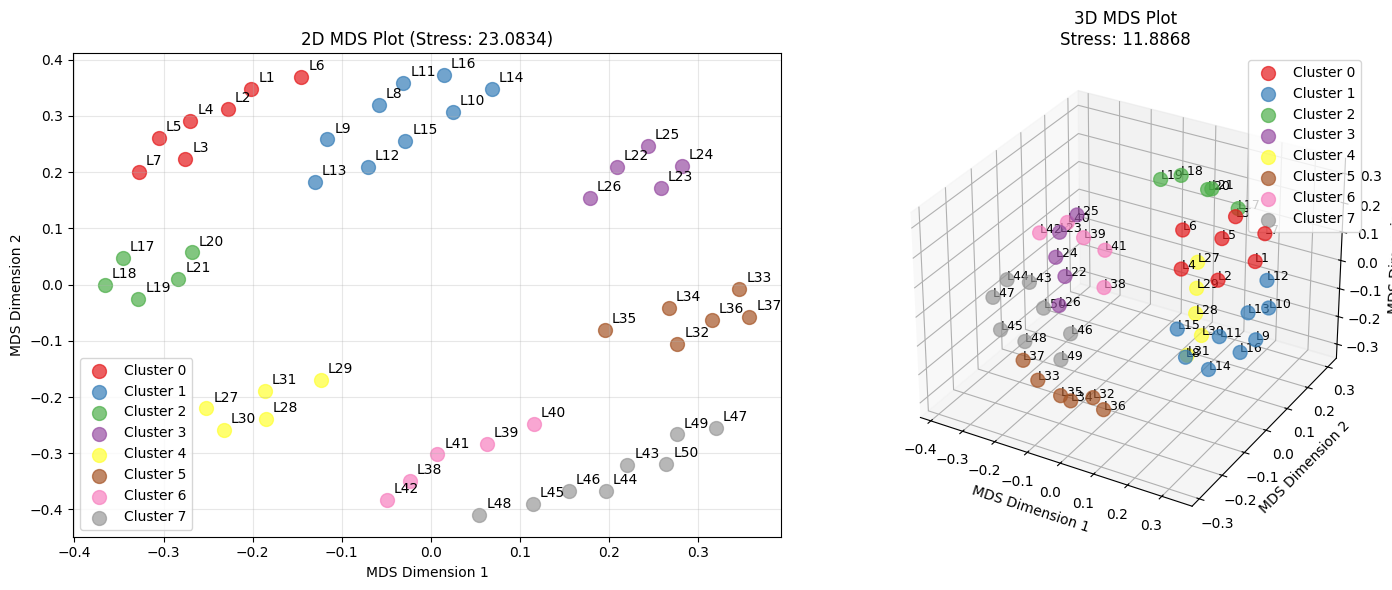


--- Distance Preservation Analysis ---
2D MDS - Correlation with original distances: 0.8882
3D MDS - Correlation with original distances: 0.8879

 --- Summary ---
Distance matrix shape: (50, 50)
Distance metric: Hamming
Mean Hamming distance: 0.4929
Std Hamming distance: 0.0990
Min Hamming distance: 0.3033
Max Hamming distance: 0.6975

 Step 3 completed. Results stored in 'mds_analysis_results' dictionary.


In [21]:
# --------------------------------------------------------------------------
#MDS Analysis
# --------------------------------------------------------------------------

print("\n=== STEP 3: MDS Analysis ===")

# Perform Multidimensional Scaling analysis to visualize high-dimensional data in 2D and 3D
mds_results, leaf_names_ordered = perform_mds_analysis(
    leaf_matrix_dict, n_components_list=[2, 3]  # Generate both 2D and 3D embeddings
)

# Create comprehensive MDS visualizations with ground truth cluster coloring
print(f"\nCreating MDS plots with ground truth cluster coloring...")
plot_mds_results(mds_results, leaf_names_ordered, true_cluster_assignments)

# Store all MDS analysis results for further use
mds_analysis_results = {
    'mds_results': mds_results,                 # Complete MDS results for 2D and 3D
    'leaf_names_ordered': leaf_names_ordered,   # Order of samples used in MDS
    'hamming_distance_matrix': mds_results[2]['hamming_distance_matrix']  # Original distance matrix
}

print(f"\n Step 3 completed. Results stored in 'mds_analysis_results' dictionary.")

### Main Analysis run

STEP 1: Hierarchical Clustering


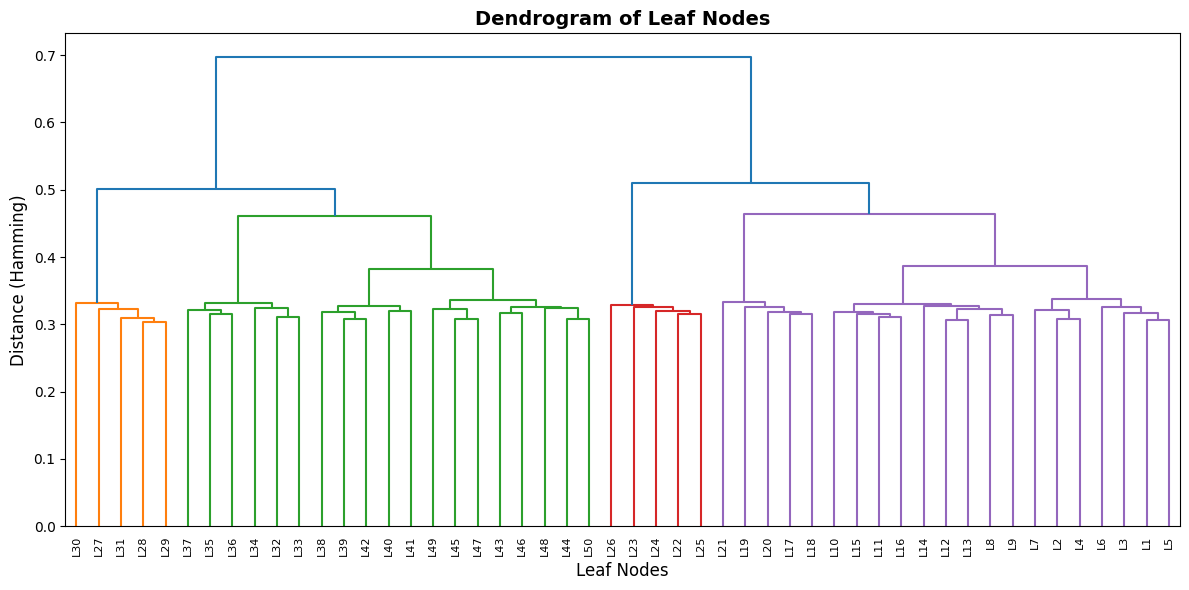


STEP 2: Significance Testing
Number of internal nodes: 49
Significant nodes (Bonferroni): 48


NameError: name 'plot_enhanced_dendrogram_with_significance' is not defined

In [8]:
# Run the complete clustering analysis
# You can use correlation_threshold='auto' for automatic selection
# or provide a specific value like correlation_threshold=0.1

results = run_kl_clustering_analysis(
    leaf_matrix_dict, 
    alpha=0.05,
    correlation_threshold='auto',  # or use a specific value like 0.1
    significance_column='Bonferroni_Result'
)

# Extract the predicted clusters
predicted_clusters = results['predicted_clusters']

print(f"\nNumber of predicted clusters: {len(set(predicted_clusters.values()))}")
print(f"Correlation threshold used: {results['correlation_threshold']:.4f}")

## Cluster Recovery Evaluation

In [13]:
# Evaluate clustering quality
print("="*60)
print("CLUSTER RECOVERY EVALUATION")
print("="*60)

# Calculate Adjusted Rand Index
leaves_ordered = sorted(predicted_clusters.keys())
true_labels = [true_cluster_assignments[leaf] for leaf in leaves_ordered]
pred_labels = [predicted_clusters[leaf] for leaf in leaves_ordered]
ari_score = adjusted_rand_score(true_labels, pred_labels)

print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")
print("(1.0 = perfect match, 0.0 = random, <0 = worse than random)")

# Count clusters
predicted_cluster_counts = {}
true_cluster_counts = {}

for leaf in predicted_clusters:
    pred_cluster = predicted_clusters[leaf]
    true_cluster = true_cluster_assignments[leaf]
    predicted_cluster_counts[pred_cluster] = predicted_cluster_counts.get(pred_cluster, 0) + 1
    true_cluster_counts[true_cluster] = true_cluster_counts.get(true_cluster, 0) + 1

print(f"\n--- Cluster Counts ---")
print(f"True clusters: {n_clusters}")
print(f"Predicted clusters: {len(predicted_cluster_counts)}")
print(f"\nTrue cluster distribution: {dict(sorted(true_cluster_counts.items()))}")
print(f"Predicted cluster distribution: {dict(sorted(predicted_cluster_counts.items()))}")

# Show detailed cluster assignments
print(f"\n--- Detailed Cluster Assignments ---")
print("Leaf | True | Pred")
print("-" * 20)
for leaf in sorted(predicted_clusters.keys())[:20]:  # Show first 20
    true_c = true_cluster_assignments[leaf]
    pred_c = predicted_clusters[leaf]
    match = "✓" if true_c == pred_c else "✗"
    print(f"{leaf:4} | {true_c:4} | {pred_c:4} {match}")

if len(predicted_clusters) > 20:
    print(f"... (showing first 20 of {len(predicted_clusters)} samples)")

# Show performance per true cluster
print(f"\n--- Cluster-wise Performance ---")
for true_cluster in sorted(true_cluster_counts.keys()):
    true_leaves = [leaf for leaf in true_cluster_assignments if true_cluster_assignments[leaf] == true_cluster]
    pred_clusters_in_true = [predicted_clusters[leaf] for leaf in true_leaves]
    most_common_pred = max(set(pred_clusters_in_true), key=pred_clusters_in_true.count)
    correct_count = pred_clusters_in_true.count(most_common_pred)
    total_count = len(true_leaves)
    accuracy = correct_count / total_count
    print(f"True Cluster {true_cluster}: {correct_count}/{total_count} correct ({accuracy:.1%}) " + 
          f"→ Predicted Cluster {most_common_pred}")

print(f"\n" + "="*60)

CLUSTER RECOVERY EVALUATION

Adjusted Rand Index (ARI): 1.0000
(1.0 = perfect match, 0.0 = random, <0 = worse than random)

--- Cluster Counts ---
True clusters: 8
Predicted clusters: 8

True cluster distribution: {0: 7, 1: 9, 2: 5, 3: 5, 4: 5, 5: 6, 6: 5, 7: 8}
Predicted cluster distribution: {1: 5, 3: 6, 5: 5, 6: 8, 8: 5, 10: 5, 12: 9, 13: 7}

--- Detailed Cluster Assignments ---
Leaf | True | Pred
--------------------
L1   |    0 |   13 ✗
L10  |    1 |   12 ✗
L11  |    1 |   12 ✗
L12  |    1 |   12 ✗
L13  |    1 |   12 ✗
L14  |    1 |   12 ✗
L15  |    1 |   12 ✗
L16  |    1 |   12 ✗
L17  |    2 |   10 ✗
L18  |    2 |   10 ✗
L19  |    2 |   10 ✗
L2   |    0 |   13 ✗
L20  |    2 |   10 ✗
L21  |    2 |   10 ✗
L22  |    3 |    8 ✗
L23  |    3 |    8 ✗
L24  |    3 |    8 ✗
L25  |    3 |    8 ✗
L26  |    3 |    8 ✗
L27  |    4 |    1 ✗
... (showing first 20 of 50 samples)

--- Cluster-wise Performance ---
True Cluster 0: 7/7 correct (100.0%) → Predicted Cluster 13
True Cluster 1: 9/9 corr

## Cluster Recovery evaluation with alternative parameters

In [1]:
def run_kl_clustering_analysis_streamlined(leaf_matrix_dict, alpha=0.05, correlation_threshold='auto', 
                                           significance_column='Bonferroni_Result'):
    """
    Streamlined version of KL-divergence based clustering analysis without plotting.
    
    Parameters:
    -----------
    leaf_matrix_dict : dict
        Dictionary mapping leaf names to binary feature vectors
    alpha : float
        Significance level for hypothesis testing (default: 0.05)
    correlation_threshold : float or 'auto'
        Threshold for correlation-based cluster refinement.
        If 'auto', uses elbow method to determine optimal threshold.
    significance_column : str
        Column name to use for significance determination
    
    Returns:
    --------
    dict
        Dictionary with cluster assignments (leaf_name -> cluster_id)
    """
    # Perform hierarchical clustering
    Z = sch.linkage(list(leaf_matrix_dict.values()), method='complete', metric='hamming')
    
    # Build tree structure
    leaf_names_original = list(leaf_matrix_dict.keys())
    root, internal_nodes = build_tree_from_dendrogram(Z, leaf_names_original, leaf_matrix_dict)
    
    # Perform significance testing
    num_columns = len(root.distribution)
    kl_divergences = [node.kl_divergence for node in internal_nodes]
    mean_kl = np.mean(kl_divergences)
    std_kl = np.std(kl_divergences)
    threshold_zero_centered = 2 * std_kl
    threshold_adaptive = mean_kl + 2 * std_kl
    
    for node in internal_nodes:
        chi2_stat = 2 * node.leaf_count * node.kl_divergence
        node.p_value = chi2.sf(chi2_stat, df=num_columns)
        corrected_alpha = alpha / node.leaf_count
        node.is_significant_bonferroni = node.p_value < corrected_alpha
        node.is_significant_zero_centered = node.kl_divergence > threshold_zero_centered
        node.is_significant_adaptive = node.kl_divergence > threshold_adaptive
    
    # Create summary DataFrame
    summary_data = []
    for node in internal_nodes:
        summary_data.append({
            'Node': node.name,
            'Mean_of_Distribution': np.mean(node.distribution),
            'Variance_of_Distribution': np.var(node.distribution),
            'P_Value': node.p_value,
            'Bonferroni_Result': "Significant" if node.is_significant_bonferroni else "Not Significant",
            'Zero_Centered_Result': "Significant" if node.is_significant_zero_centered else "Not Significant",
            'Adaptive_Result': "Significant" if node.is_significant_adaptive else "Not Significant"
        })
    node_summary_df = pd.DataFrame(summary_data)
    
    # Calculate optimal threshold if auto
    if correlation_threshold == 'auto':
        optimal_threshold, _, _, _ = _calculate_optimal_threshold(
            Z, leaf_names_original, node_summary_df, leaf_matrix_dict, significance_column
        )
        correlation_threshold = optimal_threshold
    
    # Extract clusters
    predicted_clusters, _, _ = _extract_clusters_from_tree(
        Z, leaf_names_original, node_summary_df, leaf_matrix_dict,
        significance_column, correlation_threshold
    )
    
    return predicted_clusters

In [2]:
def calculate_cluster_recovery_metrics(leaf_matrix_dict, true_cluster_assignments, 
                                       alpha=0.05, correlation_threshold='auto',
                                       significance_column='Bonferroni_Result'):
    """
    Calculate cluster recovery metrics for a given feature matrix.
    
    Parameters:
    -----------
    leaf_matrix_dict : dict
        Dictionary mapping leaf names to binary feature vectors
    true_cluster_assignments : dict
        Ground truth cluster assignments (leaf_name -> cluster_id)
    alpha : float
        Significance level for hypothesis testing
    correlation_threshold : float or 'auto'
        Threshold for correlation-based cluster refinement
    significance_column : str
        Column name to use for significance determination
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'ari': Adjusted Rand Index
        - 'median_cluster_performance': Median of cluster-wise accuracies
        - 'cluster_performances': List of individual cluster accuracies
        - 'n_predicted_clusters': Number of predicted clusters
    """
    # Run streamlined clustering
    predicted_clusters = run_kl_clustering_analysis_streamlined(
        leaf_matrix_dict, alpha, correlation_threshold, significance_column
    )
    
    # Calculate ARI
    leaves_ordered = sorted(predicted_clusters.keys())
    true_labels = [true_cluster_assignments[leaf] for leaf in leaves_ordered]
    pred_labels = [predicted_clusters[leaf] for leaf in leaves_ordered]
    ari_score = adjusted_rand_score(true_labels, pred_labels)
    
    # Calculate cluster-wise performance
    true_cluster_ids = sorted(set(true_cluster_assignments.values()))
    cluster_performances = []
    
    for true_cluster in true_cluster_ids:
        # Get all leaves in this true cluster
        true_leaves = [leaf for leaf in true_cluster_assignments 
                      if true_cluster_assignments[leaf] == true_cluster]
        
        # Get their predicted clusters
        pred_clusters_in_true = [predicted_clusters[leaf] for leaf in true_leaves]
        
        # Find the most common predicted cluster for this true cluster
        most_common_pred = max(set(pred_clusters_in_true), key=pred_clusters_in_true.count)
        
        # Calculate accuracy: fraction correctly assigned to the most common predicted cluster
        correct_count = pred_clusters_in_true.count(most_common_pred)
        total_count = len(true_leaves)
        accuracy = correct_count / total_count
        
        cluster_performances.append(accuracy)
    
    # Calculate median cluster performance
    median_performance = np.median(cluster_performances)
    
    return {
        'ari': ari_score,
        'median_cluster_performance': median_performance,
        'cluster_performances': cluster_performances,
        'n_predicted_clusters': len(set(predicted_clusters.values()))
    }

In [3]:
def _print_progress_bar(completed, total, elapsed_time, bar_length=40):
    """
    Print a progress bar with timing information.
    
    Parameters:
    -----------
    completed : int
        Number of completed tasks
    total : int
        Total number of tasks
    elapsed_time : float
        Elapsed time in seconds
    bar_length : int
        Length of the progress bar
    """
    percent = 100 * completed / total
    filled = int(bar_length * completed / total)
    bar = '█' * filled + '░' * (bar_length - filled)
    
    rate = completed / elapsed_time if elapsed_time > 0 else 0
    remaining = (total - completed) / rate if rate > 0 else 0
    
    print(f'\r[{bar}] {percent:.1f}% | {completed}/{total} | '
          f'Elapsed: {elapsed_time:.1f}s | ETA: {remaining:.1f}s | '
          f'Rate: {rate:.1f} tasks/s', end='', flush=True)

In [4]:
def _process_single_sample(args):
    """
    Helper function to process a single sample in parallel.
    This function will be called by multiprocessing.Pool.map().
    
    Parameters:
    -----------
    args : tuple
        Tuple containing (n_clusters, sample_idx, n_rows, n_cols, entropy_param, 
                         balanced_clusters, random_seed_base, alpha, 
                         correlation_threshold, significance_column)
    
    Returns:
    --------
    dict
        Dictionary with results for this sample
    """
    (n_clusters, sample_idx, n_rows, n_cols, entropy_param, 
     balanced_clusters, random_seed_base, alpha, 
     correlation_threshold, significance_column) = args
    
    # Generate random seed for this sample
    random_seed = random_seed_base + n_clusters * 1000 + sample_idx
    
    try:
        # Generate random feature matrix
        leaf_matrix_dict, true_cluster_assignments = generate_random_feature_matrix(
            n_rows=n_rows,
            n_cols=n_cols,
            entropy_param=entropy_param,
            n_clusters=n_clusters,
            random_seed=random_seed,
            balanced_clusters=balanced_clusters
        )
        
        # Calculate recovery metrics
        metrics = calculate_cluster_recovery_metrics(
            leaf_matrix_dict, 
            true_cluster_assignments,
            alpha=alpha,
            correlation_threshold=correlation_threshold,
            significance_column=significance_column
        )
        
        # Return results
        return {
            'n_clusters': n_clusters,
            'sample_idx': sample_idx,
            'random_seed': random_seed,
            'ari': metrics['ari'],
            'median_cluster_performance': metrics['median_cluster_performance'],
            'n_predicted_clusters': metrics['n_predicted_clusters'],
            'success': True
        }
        
    except Exception as e:
        # Return error result
        return {
            'n_clusters': n_clusters,
            'sample_idx': sample_idx,
            'random_seed': random_seed,
            'ari': np.nan,
            'median_cluster_performance': np.nan,
            'n_predicted_clusters': np.nan,
            'success': False,
            'error': str(e)
        }

In [17]:
def analyze_cluster_recovery_vs_cluster_number(
    n_rows, n_cols, entropy_param, cluster_numbers, 
    n_samples_per_cluster=100, balanced_clusters=True,
    alpha=0.05, correlation_threshold='auto', significance_column='Bonferroni_Result',
    random_seed_base=42, n_jobs=None
):
    """
    Analyze cluster recovery performance across different numbers of clusters using parallel processing.
    
    Parameters:
    -----------
    n_rows : int
        Number of samples in feature matrix
    n_cols : int
        Number of features in feature matrix
    entropy_param : float
        Entropy parameter for generating random matrices (0.0 to 1.0)
    cluster_numbers : list
        List of cluster numbers to test
    n_samples_per_cluster : int
        Number of random matrices to generate for each cluster number
    balanced_clusters : bool
        Whether to generate balanced cluster sizes
    alpha : float
        Significance level for hypothesis testing
    correlation_threshold : float or 'auto'
        Threshold for correlation-based cluster refinement
    significance_column : str
        Column name to use for significance determination
    random_seed_base : int
        Base random seed for reproducibility
    n_jobs : int or None
        Number of parallel jobs. If None, uses all available CPUs.
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'results': DataFrame with all results
        - 'summary': DataFrame with summary statistics per cluster number
    """
    # Determine number of parallel jobs
    if n_jobs is None:
        n_jobs = cpu_count()
    
    print("="*80)
    print("CLUSTER RECOVERY ANALYSIS vs. CLUSTER NUMBER (PARALLEL)")
    print("="*80)
    print(f"Fixed parameters:")
    print(f"  - Samples: {n_rows}")
    print(f"  - Features: {n_cols}")
    print(f"  - Entropy: {entropy_param}")
    print(f"  - Samples per cluster number: {n_samples_per_cluster}")
    print(f"  - Balanced clusters: {balanced_clusters}")
    print(f"  - Parallel jobs: {n_jobs}")
    print(f"\nVariable parameter:")
    print(f"  - Cluster numbers: {cluster_numbers}")
    print("="*80)
    
    # Prepare all tasks for parallel processing
    tasks = []
    for n_clusters in cluster_numbers:
        for sample_idx in range(n_samples_per_cluster):
            tasks.append((n_clusters, sample_idx, n_rows, n_cols, entropy_param,
                         balanced_clusters, random_seed_base, alpha,
                         correlation_threshold, significance_column))
    
    total_tasks = len(tasks)
    print(f"\nTotal tasks to process: {total_tasks}")
    print(f"Starting parallel processing with {n_jobs} workers...\n")
    
    # Process tasks in parallel with progress tracking
    start_time = time.time()
    all_results = []
    completed = 0
    
    with Pool(processes=n_jobs) as pool:
        # Use imap to get results as they complete
        for result in pool.imap(_process_single_sample, tasks, chunksize=1):
            all_results.append(result)
            completed += 1
            
            # Update progress bar every task or every 1% of completion
            if completed == 1 or completed % max(1, total_tasks // 100) == 0 or completed == total_tasks:
                elapsed = time.time() - start_time
                _print_progress_bar(completed, total_tasks, elapsed)
    
    print()  # New line after progress bar
    elapsed_time = time.time() - start_time
    print(f"\n✓ Parallel processing completed in {elapsed_time:.2f} seconds")
    print(f"  Average time per sample: {elapsed_time/total_tasks:.3f} seconds")
    
    # Report any errors
    error_count = sum(1 for r in all_results if not r['success'])
    if error_count > 0:
        print(f"\n⚠ Warning: {error_count} samples failed during processing")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Calculate summary statistics per cluster number
    summary_data = []
    for n_clusters in cluster_numbers:
        cluster_results = results_df[results_df['n_clusters'] == n_clusters]
        
        summary_data.append({
            'n_clusters': n_clusters,
            'mean_ari': cluster_results['ari'].mean(),
            'std_ari': cluster_results['ari'].std(),
            'median_ari': cluster_results['ari'].median(),
            'mean_median_cluster_performance': cluster_results['median_cluster_performance'].mean(),
            'std_median_cluster_performance': cluster_results['median_cluster_performance'].std(),
            'median_median_cluster_performance': cluster_results['median_cluster_performance'].median(),
            'mean_n_predicted_clusters': cluster_results['n_predicted_clusters'].mean(),
            'std_n_predicted_clusters': cluster_results['n_predicted_clusters'].std(),
            'median_n_predicted_clusters': cluster_results['n_predicted_clusters'].median(),
            'success_rate': cluster_results['success'].sum() / len(cluster_results)
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("\nSummary Statistics:")
    print(summary_df.to_string(index=False))
    
    # Create plots with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: ARI vs cluster number
    ax1 = axes[0]
    ax1.errorbar(summary_df['n_clusters'], summary_df['mean_ari'], 
                 yerr=summary_df['std_ari'], marker='o', capsize=5, 
                 linewidth=2, markersize=8, label='Mean ± Std')
    ax1.plot(summary_df['n_clusters'], summary_df['median_ari'], 
             marker='s', linestyle='--', linewidth=2, markersize=6, 
             label='Median', alpha=0.7)
    ax1.set_xlabel('Number of True Clusters', fontsize=12, weight='bold')
    ax1.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12, weight='bold')
    ax1.set_title('Cluster Recovery: ARI vs. Number of Clusters', fontsize=14, weight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.set_ylim([-0.1, 1.1])
    
    # Plot 2: Median cluster performance vs cluster number
    ax2 = axes[1]
    ax2.errorbar(summary_df['n_clusters'], summary_df['mean_median_cluster_performance'], 
                 yerr=summary_df['std_median_cluster_performance'], marker='o', capsize=5,
                 linewidth=2, markersize=8, label='Mean ± Std', color='green')
    ax2.plot(summary_df['n_clusters'], summary_df['median_median_cluster_performance'], 
             marker='s', linestyle='--', linewidth=2, markersize=6,
             label='Median', alpha=0.7, color='darkgreen')
    ax2.set_xlabel('Number of True Clusters', fontsize=12, weight='bold')
    ax2.set_ylabel('Median Cluster-wise Performance', fontsize=12, weight='bold')
    ax2.set_title('Cluster Recovery: Median Performance vs. Number of Clusters', 
                  fontsize=14, weight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    ax2.set_ylim([-0.1, 1.1])
    
    # Plot 3: Number of predicted clusters vs true clusters
    ax3 = axes[2]
    ax3.errorbar(summary_df['n_clusters'], summary_df['mean_n_predicted_clusters'], 
                 yerr=summary_df['std_n_predicted_clusters'], marker='o', capsize=5,
                 linewidth=2, markersize=8, label='Mean ± Std', color='purple')
    ax3.plot(summary_df['n_clusters'], summary_df['median_n_predicted_clusters'], 
             marker='s', linestyle='--', linewidth=2, markersize=6,
             label='Median', alpha=0.7, color='darkviolet')
    # Add diagonal reference line (perfect prediction)
    max_clusters = summary_df['n_clusters'].max()
    ax3.plot([0, max_clusters], [0, max_clusters], 'k--', alpha=0.3, linewidth=1.5, 
             label='Perfect prediction')
    ax3.set_xlabel('Number of True Clusters', fontsize=12, weight='bold')
    ax3.set_ylabel('Number of Predicted Clusters', fontsize=12, weight='bold')
    ax3.set_title('Predicted vs. True Number of Clusters', 
                  fontsize=14, weight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=11)
    ax3.set_xlim([0, max_clusters * 1.05])
    ax3.set_ylim([0, max(summary_df['mean_n_predicted_clusters'].max() + 
                         summary_df['std_n_predicted_clusters'].max(), 
                         max_clusters) * 1.05])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'results': results_df,
        'summary': summary_df
    }

### Example: Cluster Recovery Analysis

In [5]:
# Example: Analyze cluster recovery across different numbers of clusters
# This will test how well the algorithm recovers true clusters as complexity increases

# Define parameters
n_rows = 249           # Number of samples (keep fixed)
n_cols = 1805         # Number of features (keep fixed)
entropy_param = 0.05   # Entropy parameter (keep fixed)

# Test with different numbers of clusters
cluster_numbers = [2, 3, 4, 5] + list(range(10, 60, 5))  # 2, 3, 4, 5, then 10, 15, 20, 25, ...

# Run analysis (100 samples per cluster number)
# Note: This may take some time depending on the number of samples
recovery_analysis = analyze_cluster_recovery_vs_cluster_number(
    n_rows=n_rows,
    n_cols=n_cols,
    entropy_param=entropy_param,
    cluster_numbers=cluster_numbers,
    n_samples_per_cluster=100,  # 100 random matrices per cluster number
    balanced_clusters=True,
    alpha=0.05,
    correlation_threshold='auto',
    significance_column='Bonferroni_Result',
    random_seed_base=2025,
    n_jobs=19
)

# Access results
results_df = recovery_analysis['results']
summary_df = recovery_analysis['summary']

print("\n" + "="*80)
print("Detailed Summary Table:")
print("="*80)
print(summary_df.to_string(index=False))

NameError: name 'analyze_cluster_recovery_vs_cluster_number' is not defined